In [1]:
import cv2
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
sys.path.append("../")
%matplotlib inline

In [8]:
from vmarker import *
import pickle

In [50]:
cap = cv2.VideoCapture("Videos/square50.avi")

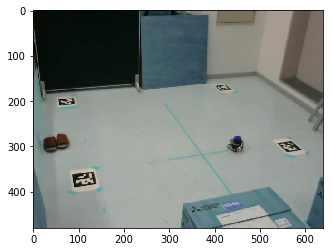

In [81]:
ok,frame = cap.read()
sframe = frame.copy()

plt.imshow(frame,cmap='gray')

In [5]:
K = np.loadtxt("../calib_usb/K.csv",delimiter=",")
dist_coef = np.loadtxt('../calib_usb/d.csv',delimiter=",")
vm = vmarker(markernum=5,K=K,dist=dist_coef,markerpos_file="roomA_ground_orig.csv")

4


In [46]:
fp= cv2.aruco.DetectorParameters_create()
fp.minDistanceToBorder

3

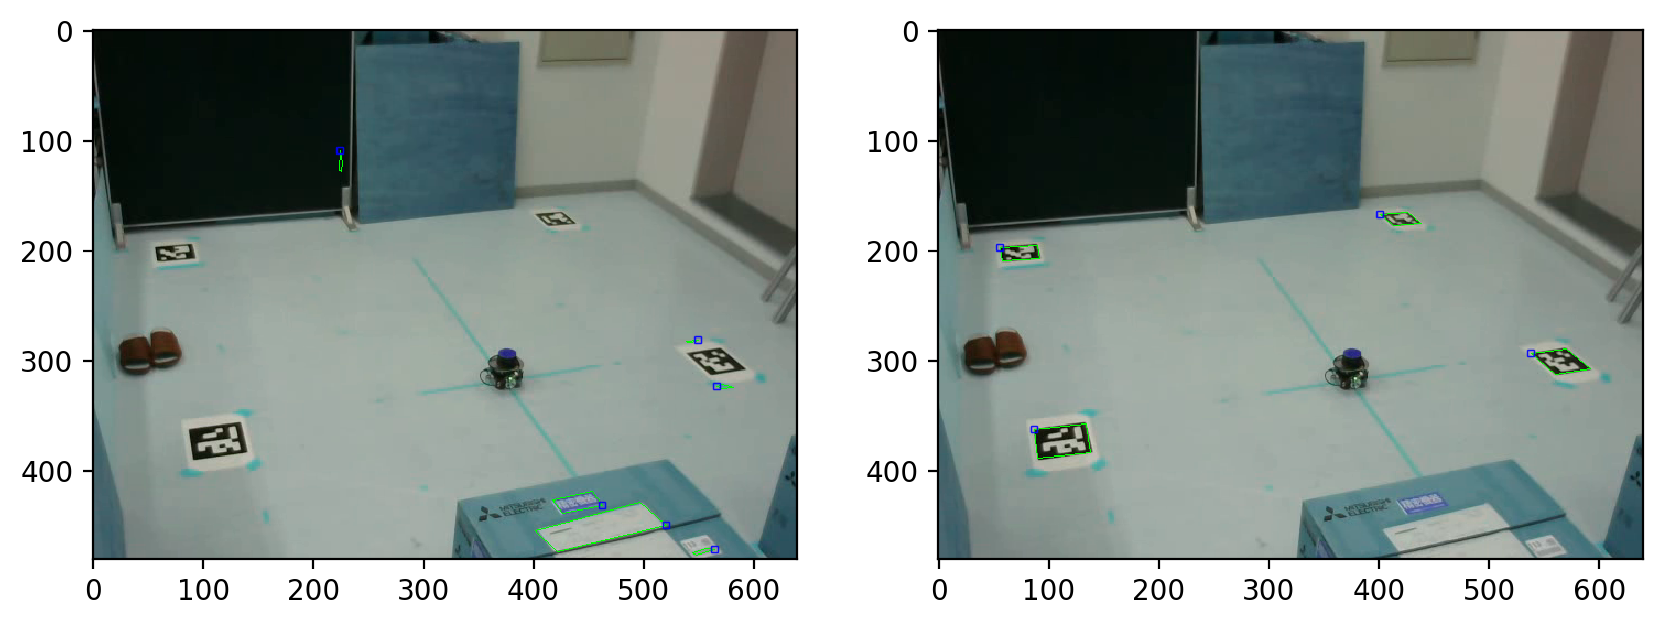

In [49]:
ok,frame = cap.read()
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame.copy(), vm.dictionary)
fig = plt.figure(figsize=(10,10),dpi=200)
plt.subplot(121)
plt.imshow(cv2.aruco.drawDetectedMarkers(frame.copy(),rejectedImgPoints))
plt.subplot(122)
plt.imshow(cv2.aruco.drawDetectedMarkers(frame.copy(),corners))


In [24]:
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(sframe.copy(), vm.dictionary)

In [33]:
vm.objp

array([[-1.426, -1.088,  0.   ],
       [-1.412,  0.912,  0.   ],
       [ 0.088, -1.088,  0.   ],
       [ 0.088,  0.912,  0.   ]])

In [30]:
centercorners= []
geometrypositions = []
for id_,corner in sorted(zip(ids,corners)): #corner=[x11,y11]...
    centercorners.append(np.average(corner,1))
    geometrypositions.append(vm.objp[id_])

In [34]:
np.array(geometrypositions).reshape(len(ids),3)

array([[-1.426, -1.088,  0.   ],
       [-1.412,  0.912,  0.   ],
       [ 0.088, -1.088,  0.   ],
       [ 0.088,  0.912,  0.   ]])

In [18]:
tv = []
while tv == []:
    cv2.destroyAllWindows()
    ok,frame = cap.read()
    sframe = frame.copy()
    cv2.startWindowThread()
    tv=vm.getcamerapose(frame)
    cv2.waitKey(1)

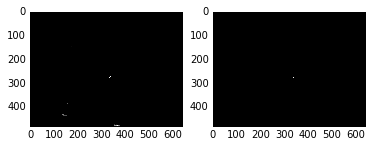

In [35]:
img = sframe

# HSV色空間に変換
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(1)
# 赤色のHSVの値域1
hsv_min = np.array([0,127,0])
hsv_max = np.array([10,255,255])
mask1 = cv2.inRange(hsv, hsv_min, hsv_max)
plt.subplot(121)
plt.imshow(mask1,cmap='gray')

# 赤色のHSVの値域2
hsv_min = np.array([150,127,0])
hsv_max = np.array([180,255,255])
mask2 = cv2.inRange(hsv, hsv_min, hsv_max)
plt.subplot(122)
plt.imshow(mask2,cmap='gray')


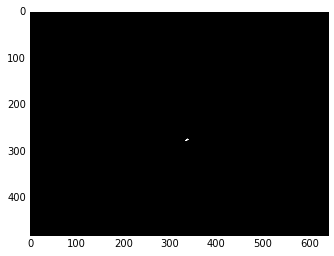

In [39]:
# RGB search
bgr_min = np.array([0,0,120])
bgr_max = np.array([50,50,255])
mask3 = cv2.inRange(img,bgr_min, bgr_max)
plt.imshow(mask3,cmap='gray')

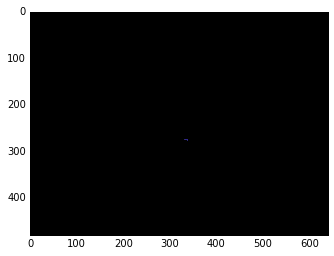

In [8]:
plt.imshow(cv2.bitwise_and(img,img,mask=mask2),cmap='gray')

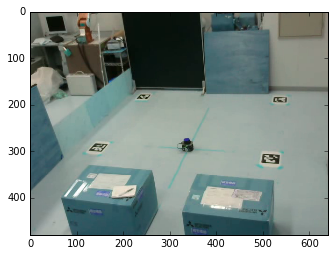

In [9]:
plt.imshow(sframe)

In [66]:
Mmt = cv2.moments(mask2)

In [71]:
# extract center of gravity
cx = Mmt['m10']/Mmt['m00']
cy = Mmt['m01']/Mmt['m00']
print([cx,cy])

[336.37931034482756, 275.17241379310343]


In [141]:
#vm.getobjpose_1([cx,cy],0.13)
vm.R,_ = cv2.Rodrigues(vm.rvecs)
pt = cv2.undistortPoints(np.array([cx,cy]).reshape(-1,1,2),vm.K,vm.dist,P=vm.K)
Rt = np.concatenate([vm.R,vm.tvecs],axis=1)
P = np.dot(K,Rt)


In [166]:
z = -0.13
A3 = - np.float32([pt[0,0,0],pt[0,0,1],1]).reshape(3,1) #A1,A2 = self.Rt[:,0],self.Rt[:,1] 
A4 = P[:,2:3]*z+P[:,3:4]

In [124]:
A3

array([[-336.37036133],
       [-275.15518188],
       [  -1.        ]], dtype=float32)

In [167]:
A = np.concatenate([P[:,0:2],A3,A4],axis=1)
U, S, V = np.linalg.svd(A) # use svd to get null space
vec = V[3]
X = vec[0]/ vec[3]
Y = vec[1]/ vec[3]
print([X,Y])
# zissai [1,1.5] ni +[0.088,-0.088]teido? [0.001,0.1]

[1.0890752595558166, 1.4249659515064161]


In [150]:
def showProj(pts):
    orig = P.dot(np.float32(pts).reshape(4,1))
    print(orig/orig[2])

In [151]:
showProj([X,Y,-0.13,1])

[[ 336.37035039]
 [ 275.15518466]
 [   1.        ]]


In [146]:
showProj([2,0,0,1])

[[ 536.33248554]
 [ 189.18650948]
 [   1.        ]]


In [152]:
# debug
#cv2.projectPoints(np.float32([2,0,0]).reshape(-1,1,3),vm.rvecs,vm.tvecs,vm.K,vm.dist)
#cv2.Rodrigues(vm.rvecs)

## Method2

In [158]:
plane2dmap = vm.objp[:,0:2].reshape(-1,1,2)

In [162]:
Homo,inliner = cv2.findHomography(vm.ccorners,plane2dmap,cv2.RANSAC,3.0)

In [168]:
posxy = cv2.perspectiveTransform(np.float32([cx,cy]).reshape(-1,1,2),Homo)
print(posxy[0,0])

[ 1.01489985  1.20405388]


In [176]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## time keisoku

In [10]:
def extractRed(img):
    # HSV色空間に変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 赤色のHSVの値域2
    hsv_min = np.array([150,127,0])
    hsv_max = np.array([179,255,255])
    mask2 = cv2.inRange(hsv, hsv_min, hsv_max)
    
    Mmt = cv2.moments(mask2)
    if Mmt["m00"] != 0:
        cx = Mmt['m10']/Mmt['m00']
        cy = Mmt['m01']/Mmt['m00']
    else:
        cx,cy = 0,0
    #print([cx,cy])
    return mask2,[cx,cy]

In [24]:
%time 500
mask,cpts = extractRed(sframe)
#cv2.imshow("mask",mask)
tv = vm.getcamerapose(sframe.copy())
if vm.PNPsolved:
    objxy = vm.getobjpose_1(cpts,-0.13)
    print([objxy[0] -1.088,objxy[1] -1.412])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
[-0.0025631627336661911, 0.0071565923749046245]


# Tracker Test

In [47]:
class RedTracker:
    def __init__(self,frame,initialize_with_hand=1,tracker='KCF',showimage=0):
        self.bboxsize = 20
        self.refreshTHDtracker = 5  # the maximum acceptable center of mass position error
        self.pos = [] # tracked 2d point

        # if init with hand:
        if initialize_with_hand:
            rect = cv2.selectROI(frame, False)
            self.bbox = (rect[0]+rect[2]/2-self.bboxsize/2,rect[1]+rect[3]/2-self.bboxsize/2,self.bboxsize,self.bboxsize)
            cv2.destroyAllWindows()
        else:   # if init automatically
            self.bbox,_ = self.find_largest_redzone_rect(frame,bboxsize=self.bboxsize)

        # show rect
        self.showrect(frame,waittime=0)
        cv2.destroyAllWindows()

        # initialize tracker
        self.get_tracker(tracker)
        self.ok = self.boxtracker.init(frame, self.bbox)

        self.showimage = showimage

    def get_tracker(self,name):
        """
        Choose tracker from key word
        """
        self.boxtracker = {
            'Boosting': cv2.TrackerBoosting_create(),
            'MIL': cv2.TrackerMIL_create(),
            'KCF' : cv2.TrackerKCF_create(),
            'TLD' : cv2.TrackerTLD_create(),
            'MedianFlow' : cv2.TrackerMedianFlow_create()
        }.get(name, 0)        

    def extractROI(self,frame,roi):
        return frame[int(roi[1]):int(roi[1]+roi[3]),int(roi[0]):int(roi[0]+roi[2])]


    def drawrect(self,frame,bbox,color=(0,255,0)):
        p1 = (int(bbox[0]), int(bbox[1]))
        p2 = (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))
        cv2.rectangle(frame, p1, p2, color, 2, 1)
        return frame

    def showrect(self,frame,waittime=1):
        # show bounding box
        framewithrect = self.drawrect(frame.copy(),self.bbox)
        cv2.putText(framewithrect, "Press Any Key to Start! Rect is " + str(self.bbox), (10,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        cv2.imshow("show bbox",framewithrect)
        cv2.waitKey(waittime)

    ## Function to be called every update 
    def track(self,frame):
        self.ok, self.bbox = self.boxtracker.update(frame)
        # track is succeed:
        if self.ok:
            _,centers,_,validnum = self.extractRed(self.extractROI(frame,self.bbox))
            self.pos = [self.bbox[0]+centers[0],self.bbox[1]+centers[1]]
            self.validpixelnum = validnum
            if self.refreshTHDtracker  <  max(abs(self.bboxsize/2 - centers[0]),abs(self.bboxsize/2 - centers[1])):
                self.bbox = (self.pos[0]-self.bboxsize/2,self.pos[1]-self.bboxsize/2,self.bboxsize,self.bboxsize)
                self.boxtracker.init(frame,self.bbox)
                print('reinit tracker!')

            if self.showimage:
                cv2.imshow("tracked", self.drawrect(frame.copy(),self.bbox))
                cv2.waitKey(1)

        else:
            print("Failed to track!")

    def getpos(self):
        return self.pos
    def getrect(self):
        return self.bbox
    def getvalidpixelnumber(self):
        return self.validpixelnum

    def find_largest_redzone_rect(self,image,bboxsize=30):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
        h = hsv[:, :, 0]
        s = hsv[:, :, 1]
        mask = np.zeros(h.shape, dtype=np.uint8)
        mask[((h < 15) | (h > 200)) & (s > 128)] = 255
        # Get boundary
        _, contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        rects = []
        
        for contour in contours:
            approx = cv2.convexHull(contour)
            rect = cv2.boundingRect(approx)
            rects.append(np.array(rect))
        largest = max(rects, key=(lambda x: x[2] * x[3])) #return maximum rectangle
        centerx = largest[0]+largest[2]/2 
        centery = largest[1]+largest[3]/2
        bbox = (centerx-bboxsize/2,centery-bboxsize/2,bboxsize,bboxsize)
        return bbox, largest
        
    def extractRed(self,image):
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV_FULL)
        h = hsv[:, :, 0]
        s = hsv[:, :, 1]
        mask = np.zeros(h.shape, dtype=np.uint8)
        mask[((h < 10) | (h > 200)) & (s > 128)] = 255

        # get RED size
        validnum = sum(mask.reshape(-1))/255
        hei,wid,_ = image.shape

        Mmt = cv2.moments(mask)
        if Mmt["m00"] != 0:
            cx = Mmt['m10']/Mmt['m00']
            cy = Mmt['m01']/Mmt['m00']
            flag = True
        else:
            cx,cy = wid/2,hei/2
            flag = False
        #print([cx,cy])
        return mask,[cx,cy],flag,validnum

In [52]:
tracker = RedTracker(frame,showimage=0,initialize_with_hand=0)

In [98]:
for i in range(30):
    ok,frame=cap.read() 
    tracker.track(frame)

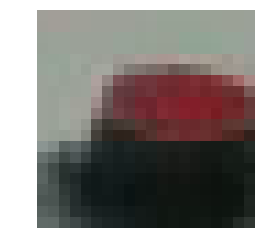

In [99]:
roi = tracker.extractROI(frame,tracker.bbox)
plt.axis('off')
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))

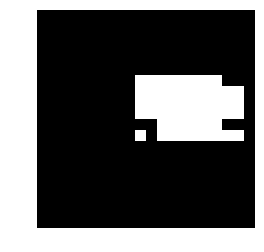

In [100]:
mask,rcenters,_,_ = tracker.extractRed(roi)
plt.axis('off')
plt.imshow(mask,cmap='gray')

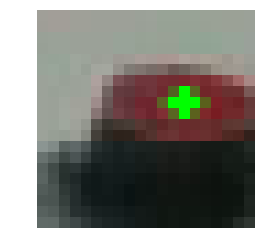

In [101]:
roi_c = cv2.circle(roi.copy(), (int(rcenters[0]), int(rcenters[1])), 1, (0, 255, 0), -1, cv2.LINE_AA)
plt.axis('off')
plt.imshow(cv2.cvtColor(roi_c, cv2.COLOR_BGR2RGB))

In [102]:
max(abs(tracker.bboxsize/2 - rcenters[0]),abs(tracker.bboxsize/2 - rcenters[1]))

3.415094339622641

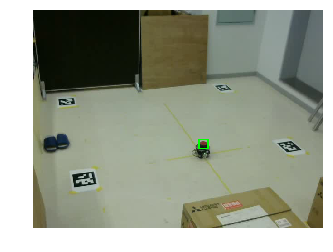

In [61]:
img = tracker.drawrect(frame.copy(),tracker.bbox)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [107]:
array = [[1,2],[5,6],[7,8]]
x = [i[0] for i in array]

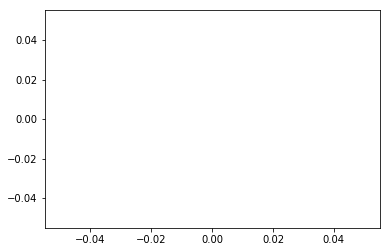